In [2]:
# Write a util function called merge_celltypes that does the 0.2 filtration and maxes them into one giant adata object with however many spots
# And then see if COMMOT can handle it.

In [3]:
import sys
import os
import importlib

sys.path.insert(0, os.path.abspath('..'))


In [4]:
import scanpy as sc
import squidpy as sq
import importlib
import model
importlib.reload(model)
from model import CitegeistModel  # Now directly import from the module
# Reload the model module if you're actively developing

import scanpy as sc
from model.utils import plot_neighbors_with_fixed_radius


cell_profiles = {
    "Cancer Cells": {
        "Major": ["EPCAM-1"],
        "Minor": ["SDC1-1",  "KRT5-1"]  # CD138 - possible cancer stem cell marker
    },
    "Macrophages": {
        "Major": ["CD68-1" ],  # General macrophage and M2-polarized macrophages
        "Minor": ["CD14-1"]  # Monocyte/macrophage lineage marker
    },
    "CD4 T Cells": {
        "Major": ["CD3E-1", "CD4-1"],  # General, Helper, and Cytotoxic T cells
    },
    "CD8 T Cells": {
        "Major": ["CD3E-1", "CD8A-1"],  # General, Helper, and Cytotoxic T cells
    },
    "B Cells": {
        "Major": ["MS4A1-1", "CD19-1"],  # General B cell markers and developmental marker
    },
    "Endothelial Cells": {
        "Major": ["PECAM1-1"],  # CD31 - endothelial cell marker
    },
    "Fibroblasts": {
        "Major": ["ACTA2-1"],  # α-SMA - myofibroblast marker, indicates activated stroma
    }
}


# Load dataset
path_to_visium_folder ="/bgfs/alee/LO_LAB/General/Lab_Data/20240510_Neil_SpatialSequencing_AgePatients/SpaceRanger_OUT/MWS23-10650/outs"
adata = sq.read.visium(path_to_visium_folder, counts_file='filtered_feature_bc_matrix.h5', load_images=True, gex_only=False)

# Initialize the model
model = CitegeistModel(sample_name="MWS23-10650", adata=adata, output_folder='/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/CITEgeist/output')

# Load cell profile dictionary
model.load_cell_profile_dict(cell_profiles)

# Preprocess and run models
# Split into gene expression and antibody capture datasets
model.split_adata()

model.filter_gex(nonzero_percentage=0.01, mean_expression_threshold=1.1, min_counts=100)

model.copy_gex_to_protein_adata()
# Preprocess datasets
model.preprocess_gex()
model.preprocess_antibody()

# Plot cell proportions (Append cell proportions) 
model.append_proportions_to_adata(key='finetuned')

# Plot cell proportions (Append cell proportions) 
model.append_gex_to_adata(pass_number=1)

prop_gex_adata = model.get_adata()

print(prop_gex_adata)

/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/COMMOT/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


CitegeistModel initialized successfully.
AnnData has been successfully split into 'gene_expression_adata' and 'antibody_capture_adata'.
Filtered gene expression data: 18085 → 10029 genes (count > 0 in at least 1.0% of spots, mean expression > 1.1 in nonzero spots). Remaining spots: 4853 Filtered spots: 4992 to 4853
Antibody capture data preprocessing completed: Winsorized, CLR applied, no NaNs detected.

Before sorting:
CSV spots 1-10: ['AACACCTACTATCGAA-1', 'AACACTTGGCAAGGAA-1', 'AACAGGAAGAGCATAG-1', 'AACAGGATTCATAGTT-1', 'AACAGGCCAACGATTA-1', 'AACAGGTTATTGCACC-1', 'AACAGGTTCACCGAAG-1', 'AACAGTCAGGCTCCGC-1', 'AACAGTCCACGCGGTG-1', 'AACAGTCGTGTCGCGG-1']
AnnData spots 1-10: ['AACACCTACTATCGAA-1', 'AACACTTGGCAAGGAA-1', 'AACAGGAAGAGCATAG-1', 'AACAGGATTCATAGTT-1', 'AACAGGCCAACGATTA-1', 'AACAGGTTATTGCACC-1', 'AACAGGTTCACCGAAG-1', 'AACAGTCAGGCTCCGC-1', 'AACAGTCCACGCGGTG-1', 'AACAGTCGTGTCGCGG-1']
✅ Cell type proportions have been appended to adata.obs and results['cell_prop']
Parquet file for 

In [5]:
import commot as ct
import scanpy as sc
import pandas as pd
import numpy as np

In [ ]:
import importlib
import model
importlib.reload(model)
from model.analysis_functions import expand_prop_gex_adata

expanded_adata = expand_prop_gex_adata(prop_gex_adata, celltype_profile_dict=cell_profiles)
print(expanded_adata)

AnnData object with n_obs × n_vars = 7362 × 10029
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'size_factors', 'original_total', 'scaled_total', 'Cancer Cells', 'Macrophages', 'CD4 T Cells', 'CD8 T Cells', 'B Cells', 'Endothelial Cells', 'Fibroblasts', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'
    uns: 'spatial'
    obsm: 'spatial'
    layers: 'B_Cells_genes_pass1', 'CD8_T_Cells_genes_pass1', 'Endothelial_Cells_genes_pass1', 'Macrophages_genes_pass1', 'Cancer_Cells_genes_pass1', 'Fibroblasts_genes_pass1', 'CD4_T_Cells_genes_pass1'


In [7]:
df_ligrec=ct.pp.ligand_receptor_database(database='CellChat', species='human')

df_cellchat_filtered = ct.pp.filter_lr_database(df_ligrec, expanded_adata, min_cell_pct=0.01)

print(df_cellchat_filtered)

         0                    1         2                   3
0    TGFB3        TGFBR1_TGFBR2      TGFb  Secreted Signaling
1    TGFB3        ACVR1B_TGFBR2      TGFb  Secreted Signaling
2    TGFB3  ACVR1_TGFBR1_TGFBR2      TGFb  Secreted Signaling
3    GDF11        TGFBR1_ACVR2A       GDF  Secreted Signaling
4    GDF11        TGFBR1_ACVR2B       GDF  Secreted Signaling
..     ...                  ...       ...                 ...
95    GAS6                  AXL       GAS  Secreted Signaling
96    GAS6                MERTK       GAS  Secreted Signaling
97     GRN                SORT1       GRN  Secreted Signaling
98  LGALS9               HAVCR2  GALECTIN  Secreted Signaling
99  LGALS9                 CD44  GALECTIN  Secreted Signaling

[100 rows x 4 columns]


In [43]:
ct.tl.spatial_communication(expanded_adata, database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=False)

KeyboardInterrupt: 

: 

In [9]:
expanded_adata.write("./examples/expanded_adata_dis_thr_500_nosum.h5ad")

... storing 'celltype' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'isotype_control' as categorical
... storing 'normalized' as categorical
... storing 'pattern' as categorical
... storing 'read' as categorical
... storing 'secondary_name' as categorical
... storing 'sequence' as categorical


In [10]:
print(expanded_adata)

AnnData object with n_obs × n_vars = 7362 × 10029
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'size_factors', 'original_total', 'scaled_total', 'Cancer Cells', 'Macrophages', 'CD4 T Cells', 'CD8 T Cells', 'B Cells', 'Endothelial Cells', 'Fibroblasts', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'
    uns: 'spatial', 'commot-cellchat-info'
    obsm: 'spatial', 'commot-cellchat-sum-sender', 'commot-cellchat-sum-receiver'
    layers: 'B_Cells_genes_pass1', 'CD8_T_Cells_genes_pass1', 'Endothelial_Cells_genes_pass1', 'Macrophages_genes_pass1', 'Cancer_Cells_genes_pass1', 'Fibroblasts_genes_pass1', 'CD4_T_Cells_genes_pass1'
    obsp: 'commot-cellchat-SEMA3C-NRP1_PLXNA2', 'commot-cellchat-SEMA3C-NRP1_PLXNA1', 'commot-cellchat-SEMA3C-NRP1_NRP2_PLXND1', 'commot-cellchat-SEMA3C-NRP2_PLXNA1', 'commot-cellchat-SEMA3C-PLXND1', 'commot-cellchat-SEMA3C-NRP1_PLXNA3', 'commot-cellchat-SEMA3C-NR

In [11]:
sender_signal = expanded_adata.obsm['commot-cellchat-sum-sender']
reciever_signal = expanded_adata.obsm['commot-cellchat-sum-receiver']


In [12]:
print(sender_signal.head())

                                 s-SEMA3C-NRP1_PLXNA2  s-SEMA3C-NRP1_PLXNA1  \
AACACTTGGCAAGGAA-1_Cancer Cells                   0.0                   0.0   
AACAGGAAGAGCATAG-1_Cancer Cells                   0.0                   0.0   
AACAGGATTCATAGTT-1_Cancer Cells                   0.0                   0.0   
AACAGGTTATTGCACC-1_Cancer Cells                   0.0                   0.0   
AACAGTCAGGCTCCGC-1_Cancer Cells                   0.0                   0.0   

                                 s-SEMA3C-NRP1_NRP2_PLXND1  \
AACACTTGGCAAGGAA-1_Cancer Cells                        0.0   
AACAGGAAGAGCATAG-1_Cancer Cells                        0.0   
AACAGGATTCATAGTT-1_Cancer Cells                        0.0   
AACAGGTTATTGCACC-1_Cancer Cells                        0.0   
AACAGTCAGGCTCCGC-1_Cancer Cells                        0.0   

                                 s-SEMA3C-NRP2_PLXNA1  s-SEMA3C-PLXND1  \
AACACTTGGCAAGGAA-1_Cancer Cells                   0.0              0.0   
AACA

In [13]:
# Calculate the mean of each column
series = sender_signal.mean()
# Filter columns with non-zero means
nonzero_series = series[series != 0]

# Sort columns by mean values in descending order
nonzero_series.sort_values(ascending=False, inplace=True)

nonzero_series.head(20)

s-total-total          5.801767
s-GDF15-TGFBR2         0.266911
s-MDK-NCL              0.265280
s-MDK-SDC2             0.262076
s-MDK-SDC4             0.253303
s-MIF-CD74_CD44        0.219422
s-MDK-LRP1             0.214262
s-SPP1-CD44            0.209603
s-SEMA3C-PLXND1        0.196324
s-CXCL12-CXCR4         0.182559
s-GRN-SORT1            0.171964
s-GAS6-MERTK           0.166259
s-TNFSF12-TNFRSF12A    0.156208
s-GAS6-AXL             0.152676
s-MIF-CD74_CXCR4       0.148956
s-POSTN-ITGAV_ITGB5    0.146911
s-SPP1-ITGAV_ITGB1     0.141066
s-C3-C3AR1             0.130534
s-NAMPT-INSR           0.110281
s-MDK-SDC1             0.102042
dtype: float64


Top 20 pathways by mean nonzero signal strength:
s-total-total          19.136472
s-FGF7-FGFR1            5.399806
s-PDGFA-PDGFRB          4.132095
s-CCL14-ACKR1           3.896929
s-LGALS9-CD44           3.873184
s-ANGPTL4-SDC4          3.703007
s-SEMA3C-PLXND1         3.677710
s-ADM-CALCRL            3.483568
s-IGF1-IGF1R            3.479351
s-TNFSF12-TNFRSF12A     3.343023
s-FGF7-FGFR2            3.277782
s-GDF15-TGFBR2          3.114105
s-SPP1-CD44             3.104831
s-ANGPTL4-SDC2          3.089560
s-LGALS9-HAVCR2         3.005030
s-PDGFB-PDGFRB          2.974114
s-NAMPT-INSR            2.868868
s-CCL8-ACKR1            2.823572
s-CSF1-CSF1R            2.809524
s-ANGPTL4-SDC3          2.793020
dtype: float64


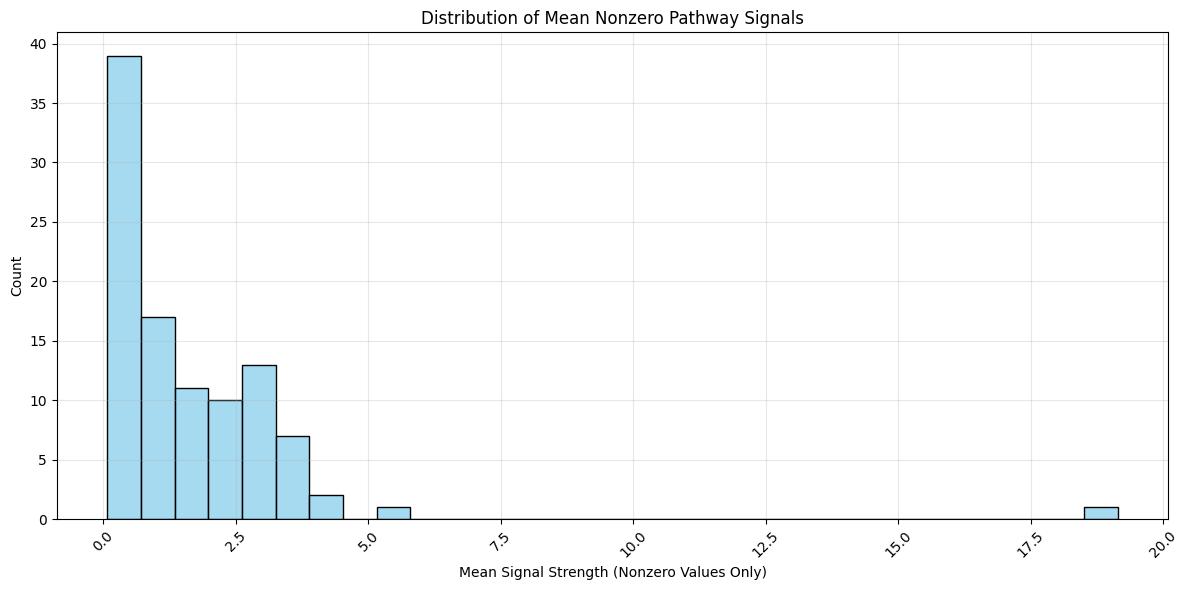

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sender_signal = expanded_adata.obsm['commot-cellchat-sum-sender']
reciever_signal = expanded_adata.obsm['commot-cellchat-sum-receiver']

# Calculate the mean of nonzero values for each column
series = sender_signal.apply(lambda x: x[x != 0].mean())
# Filter columns with non-zero means
nonzero_series = series[series != 0]

# Print top 20 pathways
print("\nTop 20 pathways by mean nonzero signal strength:")
print(nonzero_series.sort_values(ascending=False).head(20))

# Create figure and axis with a larger size
plt.figure(figsize=(12, 6))

# Create histogram using seaborn for better styling
sns.histplot(data=nonzero_series, bins=30, color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Mean Nonzero Pathway Signals', fontsize=12)
plt.xlabel('Mean Signal Strength (Nonzero Values Only)', fontsize=10)
plt.ylabel('Count', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()



In [15]:
# Add celltype as an categorial obs and then run all the ct functions.

expanded_adata.obs['celltype'] = expanded_adata.obs_names.str.split('_').str[1]
expanded_adata.obs['celltype'] = expanded_adata.obs['celltype'].astype('category')


In [16]:
# Add this before the plotting command to check for NaN values
print("NaN values in spatial coordinates:", 
      np.any(np.isnan(expanded_adata.obsm["spatial"])))

# You can also check which spots have NaN coordinates
if np.any(np.isnan(expanded_adata.obsm["spatial"])):
    nan_spots = np.where(np.isnan(expanded_adata.obsm["spatial"]).any(axis=1))[0]
    print("Spots with NaN coordinates:", nan_spots)

NaN values in spatial coordinates: True
Spots with NaN coordinates: [2716 5950]


In [17]:
# Filter out spots with NaN coordinates
valid_spots = ~np.isnan(expanded_adata.obsm["spatial"]).any(axis=1)
expanded_adata = expanded_adata[valid_spots].copy()

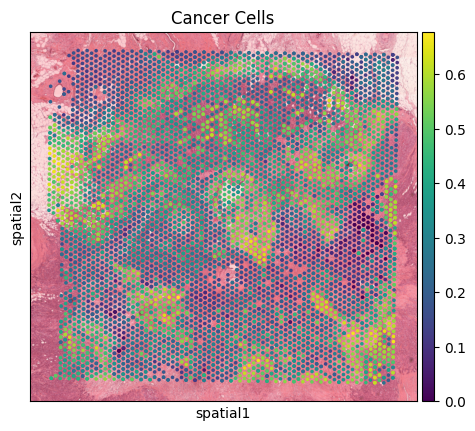

In [18]:
sc.pl.spatial(expanded_adata, color='Cancer Cells')

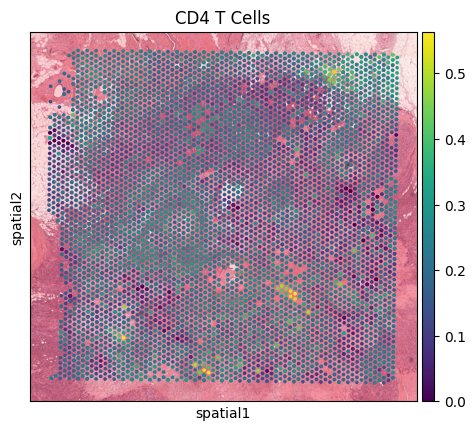

In [19]:
sc.pl.spatial(expanded_adata, color='CD4 T Cells')

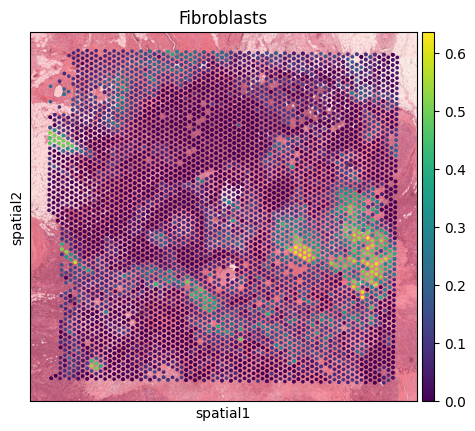

In [20]:
sc.pl.spatial(expanded_adata, color='Fibroblasts')

In [21]:
sender_signal = expanded_adata.obsm['commot-cellchat-sum-sender']

# Calculate the mean of nonzero values for each column
series = sender_signal.apply(lambda x: x[x != 0].mean())
# Filter columns with non-zero means
nonzero_series = series[series != 0]

# Print top 20 pathways
print("\nTop 20 sender pathways in Cancer Cells by mean nonzero signal strength:")
print(nonzero_series.sort_values(ascending=False).head(20))



Top 20 sender pathways in Cancer Cells by mean nonzero signal strength:
s-total-total          19.136472
s-FGF7-FGFR1            5.399806
s-PDGFA-PDGFRB          4.132095
s-CCL14-ACKR1           3.896929
s-LGALS9-CD44           3.873184
s-ANGPTL4-SDC4          3.703007
s-SEMA3C-PLXND1         3.677710
s-ADM-CALCRL            3.483568
s-IGF1-IGF1R            3.479351
s-TNFSF12-TNFRSF12A     3.343023
s-FGF7-FGFR2            3.277782
s-GDF15-TGFBR2          3.114105
s-SPP1-CD44             3.104831
s-ANGPTL4-SDC2          3.089560
s-LGALS9-HAVCR2         3.005030
s-PDGFB-PDGFRB          2.974114
s-NAMPT-INSR            2.868868
s-CCL8-ACKR1            2.823572
s-CSF1-CSF1R            2.809524
s-ANGPTL4-SDC3          2.793020
dtype: float64


In [22]:
top_20_pathways = nonzero_series.sort_values(ascending=False)

In [23]:
print(len(top_20_pathways))

101


In [29]:
sender_signal = expanded_adata.obsm['commot-cellchat-sum-sender']

# Calculate the mean of nonzero values for each column
series = sender_signal.apply(lambda x: x[x != 0].mean())
# Filter columns with non-zero means
nonzero_series = series[series != 0]

# Print top 20 pathways
print("\nTop 20 sender pathways in All Cells by mean nonzero signal strength:")
print(nonzero_series.sort_values(ascending=False).head(20))

# Across all spots, which celltypes are expressing the top 20 pathways the most?
top_20_pathways = nonzero_series.sort_values(ascending=False)

for path in top_20_pathways.index:
    path = path[2:]

    if path == 'total-total':
        continue

    # Get sender and receiver signals
    sender_signal_df = expanded_adata.obsm['commot-cellchat-sum-sender']
    receiver_signal_df = expanded_adata.obsm['commot-cellchat-sum-receiver']
    
    sender_signal = sender_signal_df[f's-{path}'].copy()
    receiver_signal = receiver_signal_df[f'r-{path}'].copy()

    # Get celltypes
    sender_celltype = sender_signal.index.str.split('_').str[1]
    receiver_celltype = receiver_signal.index.str.split('_').str[1]

    # Group by celltype and get means of nonzero values only
    sender_by_celltype = sender_signal[sender_signal != 0].groupby(sender_celltype[sender_signal != 0]).mean()
    receiver_by_celltype = receiver_signal[receiver_signal != 0].groupby(receiver_celltype[receiver_signal != 0]).mean()

    # Sort both by mean values
    sender_by_celltype = sender_by_celltype.sort_values(ascending=False)
    receiver_by_celltype = receiver_by_celltype.sort_values(ascending=False)

    print(f"\n=== {path} Pathway ===")
    print("\nTop Sending and Receiving Celltypes:")
    print("-" * 60)
    print(f"{'Sender':25} {'Signal':10} | {'Receiver':25} {'Signal':10}")
    print("-" * 60)

    # Get max length to iterate over
    max_len = max(len(sender_by_celltype), len(receiver_by_celltype))
    
    # Print side by side
    for i in range(max_len):
        sender_cell = ""
        sender_val = ""
        receiver_cell = ""
        receiver_val = ""
        
        if i < len(sender_by_celltype):
            sender_cell = sender_by_celltype.index[i]
            sender_val = f"{sender_by_celltype.iloc[i]:.4f}"
            
        if i < len(receiver_by_celltype):
            receiver_cell = receiver_by_celltype.index[i]
            receiver_val = f"{receiver_by_celltype.iloc[i]:.4f}"
            
        print(f"{sender_cell:25} {sender_val:10} | {receiver_cell:25} {receiver_val:10}")

    print("-" * 60)
    print("\n")



Top 20 sender pathways in All Cells by mean nonzero signal strength:
s-total-total          19.136472
s-FGF7-FGFR1            5.399806
s-PDGFA-PDGFRB          4.132095
s-CCL14-ACKR1           3.896929
s-LGALS9-CD44           3.873184
s-ANGPTL4-SDC4          3.703007
s-SEMA3C-PLXND1         3.677710
s-ADM-CALCRL            3.483568
s-IGF1-IGF1R            3.479351
s-TNFSF12-TNFRSF12A     3.343023
s-FGF7-FGFR2            3.277782
s-GDF15-TGFBR2          3.114105
s-SPP1-CD44             3.104831
s-ANGPTL4-SDC2          3.089560
s-LGALS9-HAVCR2         3.005030
s-PDGFB-PDGFRB          2.974114
s-NAMPT-INSR            2.868868
s-CCL8-ACKR1            2.823572
s-CSF1-CSF1R            2.809524
s-ANGPTL4-SDC3          2.793020
dtype: float64

=== FGF7-FGFR1 Pathway ===

Top Sending and Receiving Celltypes:
------------------------------------------------------------
Sender                    Signal     | Receiver                  Signal    
----------------------------------------------------

In [25]:
# Read in .tsv file from HPA
hpa_df = pd.read_csv("examples/rna_single_cell_type.tsv", sep="\t")






In [26]:
print(hpa_df['Cell type'].unique())

['Adipocytes' 'Alveolar cells type 1' 'Alveolar cells type 2' 'Astrocytes'
 'B-cells' 'Basal keratinocytes' 'Basal prostatic cells'
 'Basal respiratory cells' 'Basal squamous epithelial cells'
 'Bipolar cells' 'Breast glandular cells' 'Breast myoepithelial cells'
 'Cardiomyocytes' 'Cholangiocytes' 'Ciliated cells' 'Club cells'
 'Collecting duct cells' 'Cone photoreceptor cells' 'Cytotrophoblasts'
 'dendritic cells' 'Distal enterocytes' 'Distal tubular cells'
 'Ductal cells' 'Early spermatids' 'Endometrial stromal cells'
 'Endothelial cells' 'Enteroendocrine cells' 'Erythroid cells'
 'Excitatory neurons' 'Exocrine glandular cells'
 'Extravillous trophoblasts' 'Fibroblasts' 'Gastric mucus-secreting cells'
 'Glandular and luminal cells' 'granulocytes' 'Granulosa cells'
 'Hepatocytes' 'Hofbauer cells' 'Horizontal cells' 'Inhibitory neurons'
 'Intestinal goblet cells' 'Ionocytes' 'Kupffer cells' 'Langerhans cells'
 'Late spermatids' 'Leydig cells' 'Lymphatic endothelial cells'
 'Macrophages

global_sender_vals [0.0, 0.026387662761044005, 0.25726489948899095, 0.028157200327646074, 0.14607725597339516, 0.7168717478438893, 0.27070522693069093, 0.0, 0.02113814430755225, 0.3440401264600344, 0.056174278953776184, 0.6530612244897989, 0.42547867764823666, 0.1890708061428207, 0.0, 0.005219938242823682, 0.01671297057608522, 0.02518699249102294, 0.0, 0.4388643463102045, 0.49078646673170534, 0.0, 0.018593637788519326, 0.02627907481608181, 0.056622154119439175, 0.0, 0.3223205760193592, 0.6503776106175376, 0.0, 0.008279621923326031, 0.0872115867127352, 0.05424508269182428, 0.16688390025376107, 0.20069532973329035, 0.10141882019685651, 0.0, 0.06431519961481949, 0.0, 0.17960185829246553, 0.1632653061224492, 0.8726384357051935, 0.5126143435441467, 0.0, 0.019409937888198798, 0.22508775315727042, 0.13714308544366705, 0.0, 0.1742456912725753, 0.20980280083437208, 0.0, 0.01421977974316334, 0.042839194124878154, 0.035679553085686364, 0.09669899322301417, 0.4891255903608343, 0.3193762125816746, 

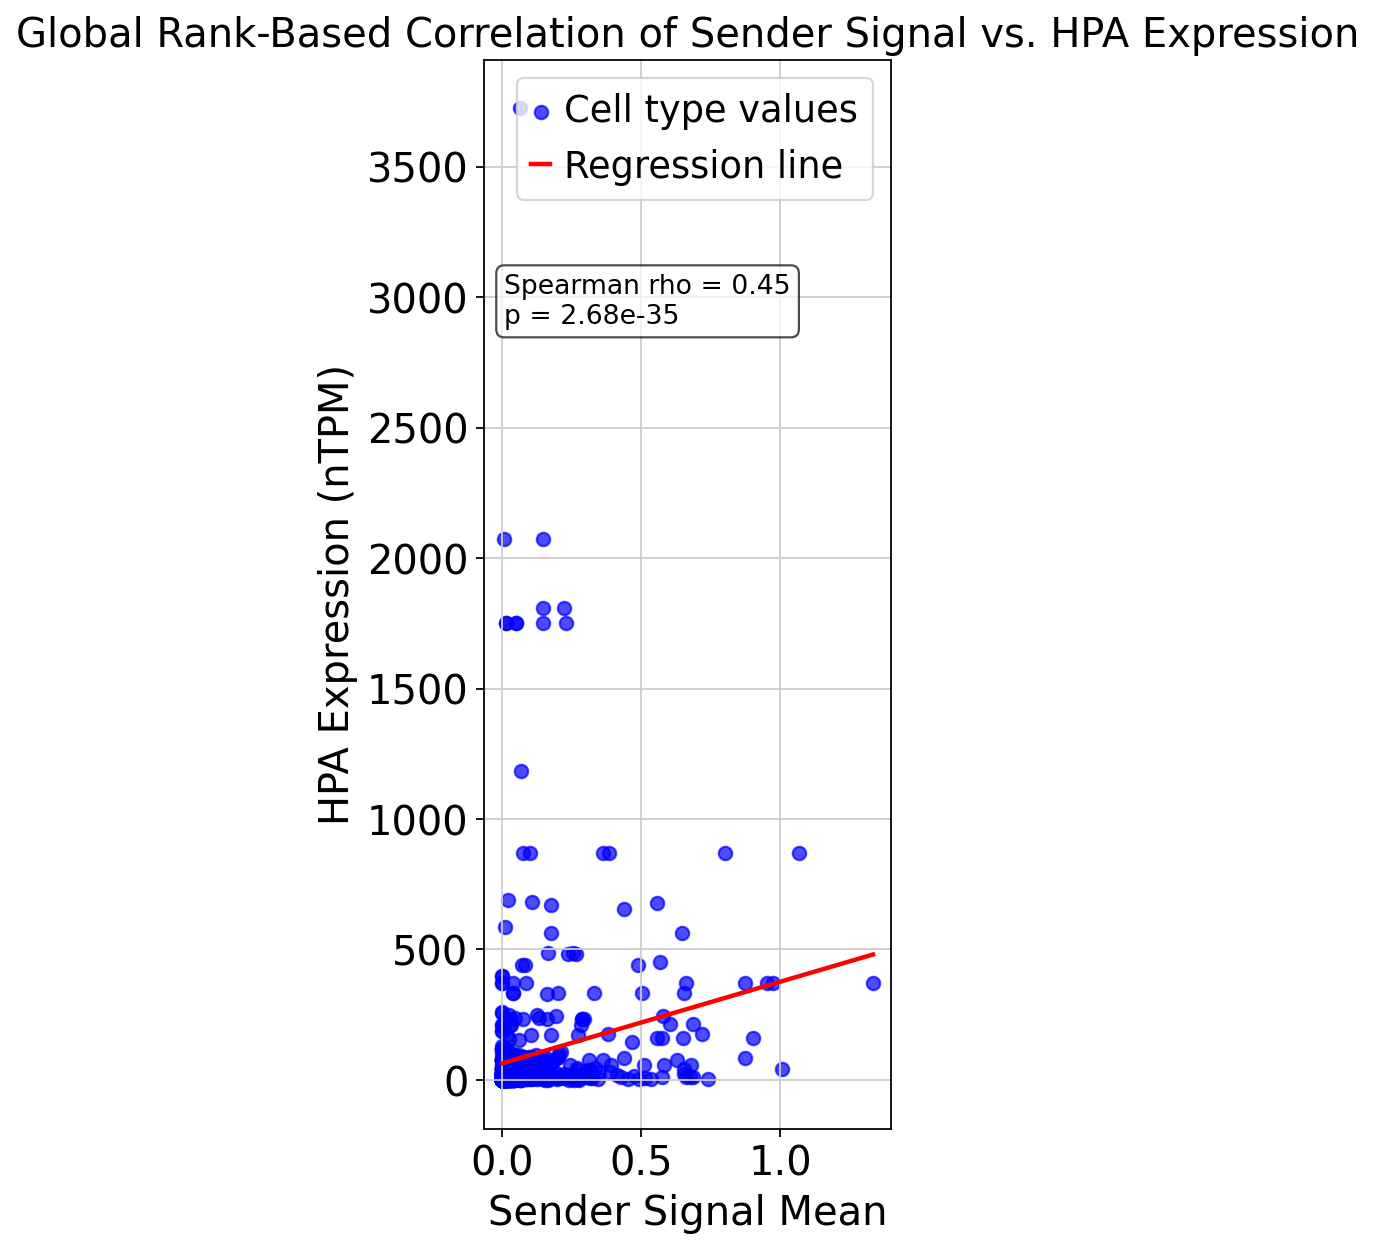

In [42]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Set up logging for debugging.
logging.basicConfig(level=logging.DEBUG, format='%(levelname)s: %(message)s')

# Define the mapping from sender cell types (from the signal data) to HPA cell types.
# Adjust these mappings as appropriate.
mapping = {
    "CD8 T Cells": "T-cells",
    "CD4 T Cells": "T-cells",
    "Fibroblasts": "Fibroblasts",
    "Macrophages": "Macrophages",
    "Cancer Cells": "Breast glandular cells",  # closest proxy to cancer in HPA
    "B Cells": "B-cells",
    "Endothelial Cells": "Endothelial cells"
}

# Containers to aggregate the per-pathway data.
global_sender_vals = []  # sender signal mean per cell type per pathway
global_hpa_vals = []     # corresponding HPA nTPM (averaged) for the mapped cell type
global_pathways   = []   # pathway labels (for debugging/plotting if desired)

# Loop over pathways from your top_20_pathways index.
for pathway in top_20_pathways.index:
    # Remove the two-character prefix (if needed) and skip a possible "total-total" entry.
    path = pathway[2:]
    if path == 'total-total':
        continue

    # 1. Identify the ligand from the pathway (assumed to be the part before the hyphen).
    ligand = path.split('-')[0]
    
    # Subset HPA data for this ligand.
    hpa_subset = hpa_df[hpa_df["Gene name"] == ligand]
    if hpa_subset.empty:
        logging.debug(f"Ligand '{ligand}' not found in HPA data for pathway '{path}'; skipping pathway.")
        continue

    # 2. Get the sender signal values for this pathway.
    sender_signal_df = expanded_adata.obsm['commot-cellchat-sum-sender']
    try:
        # Expect a column named like "s-{path}"
        sender_signal = sender_signal_df[f's-{path}'].copy()
    except KeyError:
        logging.debug(f"Sender signal column for pathway '{path}' not found; skipping pathway.")
        continue

    # Assume that the cell type is encoded in the index as "spot_celltype" (split on '_').
    sender_celltypes = sender_signal.index.str.split('_').str[1]
    unique_sender_cells = np.unique(sender_celltypes)

    # Create lists to store values for this pathway.
    pathway_sender_vals = []
    pathway_hpa_vals = []
    pathway_cells = []  # store sender cell type names (before mapping)

    # 3. For each sender cell type (from the signal data) that is in our mapping,
    #    compute the mean sender signal and get the corresponding HPA value.
    for cell in unique_sender_cells:
        if cell not in mapping:
            # Skip cell types not in our mapping.
            logging.debug(f"Sender cell type '{cell}' not in mapping dictionary; skipping.")
            continue
        mapped_cell = mapping[cell]
        # Compute the mean sender signal for this cell type.
        sender_val = np.mean(sender_signal[sender_celltypes == cell].values)
        
        # In the HPA subset, look for rows whose "Cell type" matches the mapped cell type.
        # Use case-insensitive matching.
        hpa_matches = hpa_subset[hpa_subset["Cell type"].str.lower() == mapped_cell.lower()]
        if hpa_matches.empty:
            logging.debug(f"For pathway '{path}', sender cell type '{cell}' (mapped to '{mapped_cell}') "
                          f"was not found in HPA data; skipping this cell type.")
            continue
        # Take the average nTPM value if more than one row exists.
        hpa_val = np.mean(hpa_matches["nTPM"].values)
        
        pathway_sender_vals.append(sender_val)
        pathway_hpa_vals.append(hpa_val)
        pathway_cells.append(cell)
    
    # Check that we have at least two matching cell types to compute a rank correlation.
    if len(pathway_sender_vals) < 2:
        logging.debug(f"Not enough matching cell types for pathway '{path}' to compute rank correlation; skipping.")
        continue

    # Compute the Spearman rank correlation for this pathway.
    corr, p_corr = spearmanr(pathway_sender_vals, pathway_hpa_vals)
    logging.info(f"Pathway '{path}': cell types {pathway_cells} -> Spearman rho = {corr:.2f}, p = {p_corr:.2e}")

    # Append the per-cell values to the global lists.
    global_sender_vals.extend(pathway_sender_vals)
    global_hpa_vals.extend(pathway_hpa_vals)
    global_pathways.extend([path] * len(pathway_sender_vals))

print("global_sender_vals", global_sender_vals)
print("global_hpa_vals", global_hpa_vals)

# 4. Compute the global rank-based correlation (across all pathways)
if len(global_sender_vals) >= 2:
    global_corr, global_p = spearmanr(global_sender_vals, global_hpa_vals)
    logging.info(f"Global rank-based correlation across pathways: Spearman rho = {global_corr:.2f}, p = {global_p:.2e}")

    # 5. Plotting the Global Correlation with a Regression Line
    if len(global_sender_vals) > 1:
        plt.figure(figsize=(4, 8))
        plt.scatter(global_sender_vals, global_hpa_vals, color='blue', alpha=0.7, label='Cell type values')
        plt.xlabel("Sender Signal Mean")
        plt.ylabel("HPA Expression (nTPM)")
        plt.title("Global Rank-Based Correlation of Sender Signal vs. HPA Expression")
        
        # Fit a linear regression line through the points.
        coeffs = np.polyfit(global_sender_vals, global_hpa_vals, 1)
        fit_fn = np.poly1d(coeffs)
        x_line = np.linspace(min(global_sender_vals), max(global_sender_vals), 100)
        plt.plot(x_line, fit_fn(x_line), color='red', lw=2, label='Regression line')
        
        # Annotate the plot with the Spearman correlation coefficient and p-value.
        plt.annotate(f"Spearman rho = {global_corr:.2f}\np = {global_p:.2e}",
                    xy=(0.05, 0.8), xycoords='axes fraction',
                    fontsize=12, horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        plt.legend()
        plt.tight_layout()
        plt.savefig("global_correlation_plot.svg")
        plt.show()
    else:
        logging.info("Not enough data points to generate a global correlation plot.")



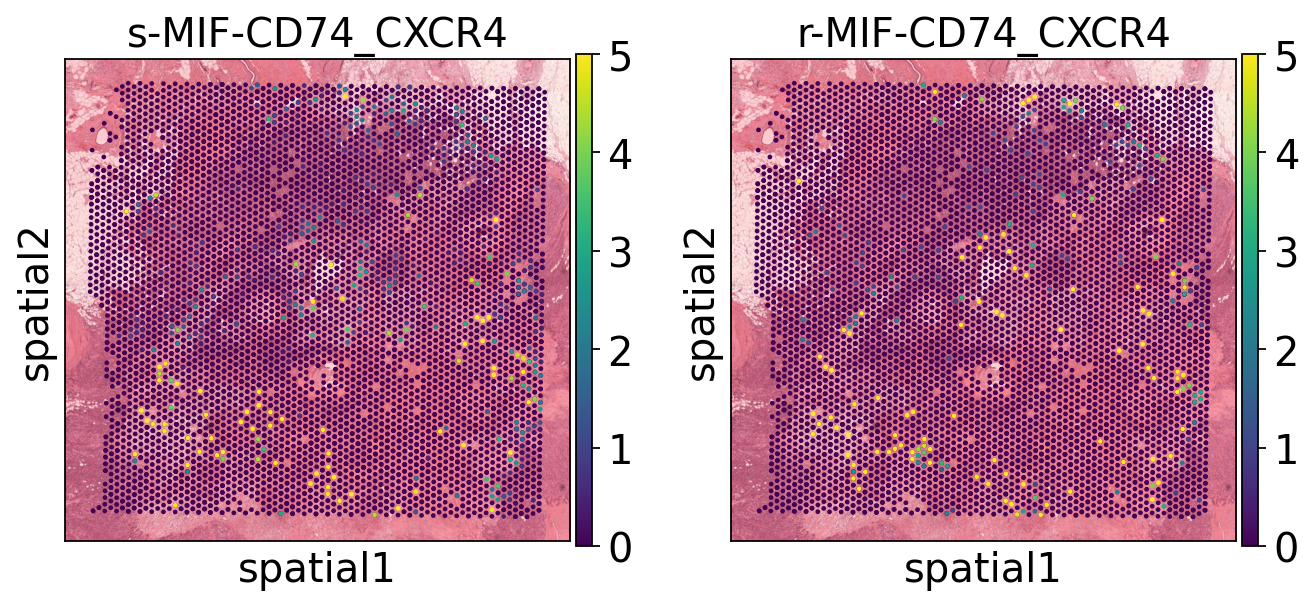

In [28]:
# Use the Midikine Pathway and do Anova Testing to see which Celltypes are significantly expressing or responding to it.
sc.set_figure_params(fontsize=18)

pathway = 'MIF-CD74_CXCR4'

if f's-{pathway}' in expanded_adata.obsm['commot-cellchat-sum-sender'].columns:
    expanded_adata.obs[f's-{pathway}'] = expanded_adata.obsm['commot-cellchat-sum-sender'][f's-{pathway}']
    expanded_adata.obs[f'r-{pathway}'] = expanded_adata.obsm['commot-cellchat-sum-receiver'][f'r-{pathway}']
else:
    expanded_adata.obs[f's-{pathway}'] = np.zeros(expanded_adata.n_obs)
    expanded_adata.obs[f'r-{pathway}'] = np.zeros(expanded_adata.n_obs)
sc.pl.spatial(expanded_adata, color=[f's-{pathway}',f'r-{pathway}'], wspace = 0.2, vmin = 0, vmax = 5)